# 1. 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 2. 데이터 로드
- 읍,면,동을 제외한 시도 수준의 성별/연령별 1인가구 데이터프레임을 만든다.

In [3]:
df01 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-01 성별_연령별_교육정도별_1인가구_일반가구_시군구_20230318231134.csv',encoding='cp949')
df01, df01.columns = df01[1:] , df01.iloc[0]
df01.head(20)

,행정구역별(시군구),성별,연령별,1인가구,초등학교,중학교,고등학교,대학(4년제미만),대학교(4년제이상),대학원,안받았음(미취학 포함)
1,전국,계,합계,6643354,664611,567153,2016517,796250,1940866,351921,306036
2,전국,계,20세 미만,72119,-,1695,23440,12158,34826,-,-
3,전국,계,20~24,496119,-,2507,84389,92363,307180,9680,-
4,전국,계,25~29,775110,-,3357,122675,151449,436774,60855,-
5,전국,계,30~34,618316,-,3846,100010,118489,332474,63497,-
6,전국,계,35~39,497027,-,6788,127345,108068,208461,46365,-
7,전국,계,40~44,427257,-,9500,148384,88656,144048,36669,-
8,전국,계,45~49,476499,1460,18239,224032,72789,122626,37353,-
9,전국,계,50~54,497959,4028,39476,260424,52672,110092,31267,-
10,전국,계,55~59,541536,15364,83281,285067,40423,92364,25037,-


In [4]:
# 미관측값을 0으로 대체
df01 = df01.replace('-', '0')
df01 = df01.astype({'1인가구':'int', '초등학교':'int', '중학교':'int', '고등학교':'int', '대학(4년제미만)':'int', '대학교(4년제이상)':'int', '대학원':'int', '안받았음(미취학 포함)':'int'})

In [5]:
def clean_df(df01):
  # 전국단위, 읍면동, 합계들을 제거
  df01 = df01[df01['행정구역별(시군구)'] != '전국']
  df01 = df01[df01['행정구역별(시군구)'] != '읍부']
  df01 = df01[df01['행정구역별(시군구)'] != '면부']
  df01 = df01[df01['행정구역별(시군구)'] != '동부']
  df01 = df01[df01['성별'] != '계']
  df01 = df01[df01['연령별'] != '합계']

  df01.연령별 = df01.연령별.str.replace('세','')

  # 키로 쓰일 컬럼 생성
  df01['행정구역_성별_연령']=df01['행정구역별(시군구)']+df01['성별']+df01['연령별']

  # 75세 이상의 합계를 구하기 위해 각 연령대를 데이터프레임으로 추출한다.
  df01_0 = df01[df01['연령별'] == '70~74']
  df01_1 = df01[df01['연령별'] == '75~79']
  df01_2 = df01[df01['연령별'] == '80~84']
  df01_3 = df01[df01['연령별'] == '85 이상']
  d = pd.concat([df01_0, df01_1, df01_2, df01_3])

  # 시도별, 성별, 75세 이상의 합계를 계산하고 키를 부여한다.
  over70 = d.groupby(by=['행정구역별(시군구)','성별']).sum().reset_index()
  over70['행정구역_성별_연령'] = over70['행정구역별(시군구)'] + over70['성별'] + '70 이상'

  # 합계 계산했으므로 원 데이터프레임에서 제거한다.
  df01 = df01[df01['연령별'] != '70~74']
  df01 = df01[df01['연령별'] != '75~79']
  df01 = df01[df01['연령별'] != '80~84']
  df01 = df01[df01['연령별'] != '85 이상']
  df01 = pd.concat([df01, over70], ignore_index=True)

  df01.drop(labels=['행정구역별(시군구)', '성별', '연령별'], axis=1, inplace=True)

  return df01


In [6]:
df01 = clean_df(df01)
df01.drop(labels=['1인가구'], axis=1, inplace=True)
df01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   초등학교          408 non-null    int64 
 1   중학교           408 non-null    int64 
 2   고등학교          408 non-null    int64 
 3   대학(4년제미만)     408 non-null    int64 
 4   대학교(4년제이상)    408 non-null    int64 
 5   대학원           408 non-null    int64 
 6   안받았음(미취학 포함)  408 non-null    int64 
 7   행정구역_성별_연령    408 non-null    object
dtypes: int64(7), object(1)
memory usage: 25.6+ KB


In [7]:
df02 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-02 성별_연령별_혼인상태별_1인가구_일반가구_시군구_20230318231109.csv',encoding='cp949')
df02, df02.columns = df02[1:] , df02.iloc[0]
df02.head()

,행정구역별(시군구),성별,연령별,1인가구,미혼,배우자 있음,사별,이혼
1,전국,계,합계,6643354,3340537,874341,1361817,1066659
2,전국,계,20세 미만,72119,72119,-,-,-
3,전국,계,20~24,496119,494422,1098,15,584
4,전국,계,25~29,775110,760813,10169,177,3951
5,전국,계,30~34,618316,571902,32912,500,13002


In [8]:
# 미관측값을 0으로 대체
df02 = df02.replace('-', '0')
df02 = df02.astype({'1인가구':'int', '미혼':'int', '배우자 있음':'int', '사별':'int', '이혼':'int'})

In [9]:
df02 = clean_df(df02)
df02.drop(labels=['1인가구'], axis=1, inplace=True)
df02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   미혼          408 non-null    int64 
 1   배우자 있음      408 non-null    int64 
 2   사별          408 non-null    int64 
 3   이혼          408 non-null    int64 
 4   행정구역_성별_연령  408 non-null    object
dtypes: int64(4), object(1)
memory usage: 16.1+ KB


In [10]:
df14 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-14 성별_연령별_사회활동별_1인가구_20세_이상__일반가구_시도_20230318225835.csv',encoding='cp949')
df14, df14.columns = df14[1:] , df14.iloc[0]
df14.head(20)

,행정구역별,성별,연령별,1인가구(20세이상 인구)-계,사회분야단체,경제분야단체,문화분야단체,정치분야단체,종교분야단체,지역단체,친목단체,교육단체,기타,없음
1,전국,계,합계,6571235,221852,90939,622454,38920,388794,78606,657931,59528,518,4827398
2,전국,계,20~24세,496119,18547,3392,46301,780,16246,2044,27146,2428,358,397625
3,전국,계,25~29세,775110,26126,11681,96211,1885,31797,5030,63020,6162,105,575103
4,전국,계,30~34세,618316,21480,10775,93798,5165,27664,5182,56868,8713,21,429841
5,전국,계,35~39세,497027,18869,9149,68535,5028,23129,4986,43204,6686,12,349541
6,전국,계,40~44세,427257,15930,8903,52221,5293,19123,5526,41214,7507,3,302237
7,전국,계,45~49세,476499,19331,10821,55440,6377,24438,6571,56754,8337,10,329355
8,전국,계,50~54세,497959,22538,10783,53793,5986,29218,7260,71274,8249,5,339810
9,전국,계,55~59세,541536,24005,9420,48718,3471,35647,8197,82182,4919,-,376001
10,전국,계,60~64세,580701,22517,7415,42780,2516,45056,8934,82547,3007,-,411439


In [11]:
# 미관측값을 0으로 대체
df14 = df14.replace('-', '0')
df14 = df14.astype({'1인가구(20세이상 인구)-계':'int', '사회분야단체':'int', '경제분야단체':'int', '문화분야단체':'int', '정치분야단체':'int', '종교분야단체':'int',
                    '지역단체':'int', '친목단체':'int', '교육단체':'int', '기타':'int', '없음':'int'})

In [12]:
def clean_df_2(df14):
  # 전국단위, 읍면동, 합계들을 제거
  df14 = df14[df14['행정구역별'] != '전국']
  df14 = df14[df14['행정구역별'] != '읍부']
  df14 = df14[df14['행정구역별'] != '면부']
  df14 = df14[df14['행정구역별'] != '동부']
  df14 = df14[df14['성별'] != '계']
  df14 = df14[df14['연령별'] != '합계']

  df14.연령별 = df14.연령별.str.replace('세','')

  # 키로 쓰일 컬럼 생성
  df14['행정구역_성별_연령'] = df14['행정구역별'] + df14['성별'] + df14['연령별']

  # 75세 이상의 합계를 구하기 위해 각 연령대를 데이터프레임으로 추출한다.
  df14_0 = df14[df14['연령별'] == '70~74']
  df14_1 = df14[df14['연령별'] == '75 이상']
  d = pd.concat([df14_0, df14_1])

  # 시도별, 성별, 75세 이상의 합계를 계산하고 키를 부여한다.
  over70 = d.groupby(by=['행정구역별','성별']).sum().reset_index()
  over70['행정구역_성별_연령'] = over70['행정구역별'] + over70['성별'] + '70 이상'

  # 합계 계산했으므로 원 데이터프레임에서 제거한다.
  df14 = df14[df14['연령별'] != '70~74']
  df14 = df14[df14['연령별'] != '75 이상']
  df14 = pd.concat([df14, over70], ignore_index=True)

  df14.drop(labels=['행정구역별', '성별', '연령별'], axis=1, inplace=True)

  return df14

In [13]:
df14 = clean_df_2(df14)
df14.drop(labels=['1인가구(20세이상 인구)-계'], axis=1, inplace=True)
df14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   사회분야단체      374 non-null    int64 
 1   경제분야단체      374 non-null    int64 
 2   문화분야단체      374 non-null    int64 
 3   정치분야단체      374 non-null    int64 
 4   종교분야단체      374 non-null    int64 
 5   지역단체        374 non-null    int64 
 6   친목단체        374 non-null    int64 
 7   교육단체        374 non-null    int64 
 8   기타          374 non-null    int64 
 9   없음          374 non-null    int64 
 10  행정구역_성별_연령  374 non-null    object
dtypes: int64(10), object(1)
memory usage: 32.3+ KB


In [14]:
df03 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-03 성별_연령별_경제활동상태별_1인가구_15세_이상__일반가구_시도_20230318231045.csv',encoding='cp949')
df03, df03.columns = df03[1:] , df03.iloc[0]
df03.head(20)

,행정구역별,성별,연령별,1인가구(15세 이상),일하였음-계,주로 일하였음,틈틈이 일하였음,일시 휴직,일하지 않았음,미상
1,전국,계,합계,6642988,4109902,3741683,247730,120489,2533086,-
2,전국,계,15~19세,71753,20264,8819,11046,399,51489,-
3,전국,계,20~24세,496119,253801,163836,84586,5379,242318,-
4,전국,계,25~29세,775110,635578,575367,45701,14510,139532,-
5,전국,계,30~34세,618316,545083,509702,20498,14883,73233,-
6,전국,계,35~39세,497027,430971,405180,10727,15064,66056,-
7,전국,계,40~44세,427257,360478,338440,8604,13434,66779,-
8,전국,계,45~49세,476499,387582,363619,10303,13660,88917,-
9,전국,계,50~54세,497959,382982,360149,10114,12719,114977,-
10,전국,계,55~59세,541536,375025,352582,10701,11742,166511,-


In [15]:
# 미관측값을 0으로 대체
df03.연령별 = df03.연령별.replace('15~19세', '20 미만')
df03 = df03.replace('-', '0')
df03 = df03.astype({'1인가구(15세 이상)':'int', '일하였음-계':'int', '주로 일하였음':'int', '틈틈이 일하였음':'int', '일시 휴직':'int', '일하지 않았음':'int', '미상':'int'})
df03.rename(columns={'미상':'경제활동 미상'})

,행정구역별,성별,연령별,1인가구(15세 이상),일하였음-계,주로 일하였음,틈틈이 일하였음,일시 휴직,일하지 않았음,경제활동 미상
1,전국,계,합계,6642988,4109902,3741683,247730,120489,2533086,0
2,전국,계,20 미만,71753,20264,8819,11046,399,51489,0
3,전국,계,20~24세,496119,253801,163836,84586,5379,242318,0
4,전국,계,25~29세,775110,635578,575367,45701,14510,139532,0
5,전국,계,30~34세,618316,545083,509702,20498,14883,73233,0
...,...,...,...,...,...,...,...,...,...,...
815,제주특별자치도,여자,50~54세,3587,2577,2309,153,115,1010,0
816,제주특별자치도,여자,55~59세,3665,2472,2247,143,82,1193,0
817,제주특별자치도,여자,60~64세,3839,2269,2066,117,86,1570,0
818,제주특별자치도,여자,65~69세,2974,1460,1358,70,32,1514,0


In [16]:
df03 = clean_df_2(df03)
df03.drop(labels=['1인가구(15세 이상)','일하였음-계'], axis=1, inplace=True)
df03.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   주로 일하였음     408 non-null    int64 
 1   틈틈이 일하였음    408 non-null    int64 
 2   일시 휴직       408 non-null    int64 
 3   일하지 않았음     408 non-null    int64 
 4   미상          408 non-null    int64 
 5   행정구역_성별_연령  408 non-null    object
dtypes: int64(5), object(1)
memory usage: 19.2+ KB


In [17]:
df15 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-15 성별_연령별_산업별_1인가구_15세_이상__일반가구_시도_20230318230027.csv',encoding='cp949')
df15, df15.columns = df15[1:] , df15.iloc[0]
df15.head(20)

,행정구역별,성별,연령별,취업 1인가구(15세 이상)-계,농업 임업 및 어업,광업,제조업,전기가스증기 및공기조절 공급업,수도 하수 및 폐기물 처리 원료 재생업,건설업,...,전문과학 및 기술 서비스업,사업시설관리 사업지원 및 임대서비스업,공공행정국방 및 사회보장 행정,교육 서비스업,보건업 및 사회복지 서비스업,예술 스포츠 및 여가관련 서비스업,협회 및 단체 수리 및 기타개인서비스업,가구 내 고용활동 및 달리 분류되지 않은 자가소비 생산 활동,국제 및 외국기관,미상
1,전국,계,합계,4109902,140866,2698,697179,20282,20890,279425,...,207130,198733,236412,263601,348060,90453,166612,6831,2345,-
2,전국,계,15~19세,20264,105,26,3099,135,31,396,...,629,454,663,1597,503,821,923,37,-,-
3,전국,계,20~24세,253801,804,64,33996,1665,686,5976,...,14475,7894,11632,27118,26799,9840,10544,148,77,-
4,전국,계,25~29세,635578,2344,189,116310,4247,2559,21349,...,52142,23036,40327,52337,67916,16656,20299,218,358,-
5,전국,계,30~34세,545083,2590,211,113206,3646,2172,22895,...,45232,21357,34786,40751,38377,12945,17034,76,274,-
6,전국,계,35~39세,430971,3309,277,92515,1970,2051,25913,...,28280,18705,20946,30170,24204,9850,16253,113,202,-
7,전국,계,40~44세,360478,3974,244,74130,1611,2150,29093,...,19233,16882,16988,25370,18403,7494,14826,153,239,-
8,전국,계,45~49세,387582,6561,363,72440,1977,2445,40629,...,15915,19316,16995,24662,20158,7804,17212,261,170,-
9,전국,계,50~54세,382982,10987,351,67204,2196,2568,45325,...,11672,19517,17763,21515,23371,7176,17734,491,313,-
10,전국,계,55~59세,375025,16995,392,59708,1607,2762,41448,...,8435,22131,15767,17421,29820,7299,17846,1216,285,-


In [18]:
df15.columns

Index(['행정구역별', '성별', '연령별', '취업 1인가구(15세 이상)-계', '농업 임업 및 어업', '광업', '제조업',
       '전기가스증기 및공기조절 공급업', '수도 하수 및 폐기물 처리 원료 재생업', '건설업', '도매 및 소매업',
       '운수업 및 창고업', '숙박 및 음식점업', '정보통신업', '금융 및 보험업', '부동산업', '전문과학 및 기술 서비스업',
       '사업시설관리 사업지원 및 임대서비스업', '공공행정국방 및 사회보장 행정', '교육 서비스업',
       '보건업 및 사회복지 서비스업', '예술 스포츠 및 여가관련 서비스업', '협회 및 단체 수리 및 기타개인서비스업',
       '가구 내 고용활동 및 달리 분류되지 않은 자가소비 생산 활동', '국제 및 외국기관', '미상'],
      dtype='object', name=0)

In [19]:
# 미관측값을 0으로 대체
df15.연령별 = df15.연령별.replace('15~19세', '20 미만')
df15 = df15.replace('-', '0')
df15 = df15.astype({'취업 1인가구(15세 이상)-계':'int', '농업 임업 및 어업':'int', '광업':'int', '제조업':'int',
       '전기가스증기 및공기조절 공급업':'int', '수도 하수 및 폐기물 처리 원료 재생업':'int', '건설업':'int', '도매 및 소매업':'int',
       '운수업 및 창고업':'int', '숙박 및 음식점업':'int', '정보통신업':'int', '금융 및 보험업':'int', '부동산업':'int', '전문과학 및 기술 서비스업':'int',
       '사업시설관리 사업지원 및 임대서비스업':'int', '공공행정국방 및 사회보장 행정':'int', '교육 서비스업':'int',
       '보건업 및 사회복지 서비스업':'int', '예술 스포츠 및 여가관련 서비스업':'int', '협회 및 단체 수리 및 기타개인서비스업':'int',
       '가구 내 고용활동 및 달리 분류되지 않은 자가소비 생산 활동':'int', '국제 및 외국기관':'int', '미상':'int'})
df15.rename(columns={'미상':'산업 미상'})

,행정구역별,성별,연령별,취업 1인가구(15세 이상)-계,농업 임업 및 어업,광업,제조업,전기가스증기 및공기조절 공급업,수도 하수 및 폐기물 처리 원료 재생업,건설업,...,전문과학 및 기술 서비스업,사업시설관리 사업지원 및 임대서비스업,공공행정국방 및 사회보장 행정,교육 서비스업,보건업 및 사회복지 서비스업,예술 스포츠 및 여가관련 서비스업,협회 및 단체 수리 및 기타개인서비스업,가구 내 고용활동 및 달리 분류되지 않은 자가소비 생산 활동,국제 및 외국기관,산업 미상
1,전국,계,합계,4109902,140866,2698,697179,20282,20890,279425,...,207130,198733,236412,263601,348060,90453,166612,6831,2345,0
2,전국,계,20 미만,20264,105,26,3099,135,31,396,...,629,454,663,1597,503,821,923,37,0,0
3,전국,계,20~24세,253801,804,64,33996,1665,686,5976,...,14475,7894,11632,27118,26799,9840,10544,148,77,0
4,전국,계,25~29세,635578,2344,189,116310,4247,2559,21349,...,52142,23036,40327,52337,67916,16656,20299,218,358,0
5,전국,계,30~34세,545083,2590,211,113206,3646,2172,22895,...,45232,21357,34786,40751,38377,12945,17034,76,274,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,제주특별자치도,여자,50~54세,2577,148,0,66,6,0,44,...,60,105,131,177,275,81,200,0,0,0
816,제주특별자치도,여자,55~59세,2472,178,0,34,7,0,44,...,53,68,53,127,308,133,224,0,0,0
817,제주특별자치도,여자,60~64세,2269,393,0,56,0,11,49,...,0,91,71,51,334,54,92,15,0,0
818,제주특별자치도,여자,65~69세,1460,290,0,21,0,0,44,...,4,46,64,20,204,29,88,11,0,0


In [20]:
df15 = clean_df_2(df15)
df15.drop(labels=['취업 1인가구(15세 이상)-계'], axis=1, inplace=True)
df15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   농업 임업 및 어업                         408 non-null    int64 
 1   광업                                 408 non-null    int64 
 2   제조업                                408 non-null    int64 
 3   전기가스증기 및공기조절 공급업                   408 non-null    int64 
 4   수도 하수 및 폐기물 처리 원료 재생업              408 non-null    int64 
 5   건설업                                408 non-null    int64 
 6   도매 및 소매업                           408 non-null    int64 
 7   운수업 및 창고업                          408 non-null    int64 
 8   숙박 및 음식점업                          408 non-null    int64 
 9   정보통신업                              408 non-null    int64 
 10  금융 및 보험업                           408 non-null    int64 
 11  부동산업                               408 non-null    int64 
 12  전문과학 및 기

In [21]:
df16 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-16 성별_연령별_직업별_1인가구_15세_이상__일반가구_시도_20230318230133.csv',encoding='cp949')
df16, df16.columns = df16[1:] , df16.iloc[0]
df16.head(20)

,행정구역별,성별,연령별,취업 1인가구(15세 이상)-계,관리자,전문가 및 관련 종사자,사무 종사자,서비스 종사자,판매 종사자,농림어업 숙련 종사자,기능원 및 관련 기능 종사자,장치·기계조작 및 조립 종사자,단순 노무 종사자,기타,미상
1,전국,계,합계,4109902,26077,883897,786364,551463,400172,138491,366781,468436,468192,20029,-
2,전국,계,15~19세,20264,89,1769,3191,6520,2972,100,1005,2148,2469,1,-
3,전국,계,20~24세,253801,404,63202,51700,54020,28627,923,13188,20584,17277,3876,-
4,전국,계,25~29세,635578,1600,222326,156171,72475,54575,2102,38052,55211,26485,6581,-
5,전국,계,30~34세,545083,1767,180452,143883,52053,50149,2360,35688,52722,22656,3353,-
6,전국,계,35~39세,430971,2022,117109,105985,42916,45547,3176,37399,50449,24653,1715,-
7,전국,계,40~44세,360478,2453,83364,80470,37025,39507,3896,38466,47453,26093,1751,-
8,전국,계,45~49세,387582,3393,72895,79432,43622,43651,6521,48163,55187,33168,1550,-
9,전국,계,50~54세,382982,4724,57286,65526,51948,40600,10913,50606,57043,43372,964,-
10,전국,계,55~59세,375025,4958,42655,48417,65037,36884,17042,47477,56597,55744,214,-


In [22]:
df16.columns

Index(['행정구역별', '성별', '연령별', '취업 1인가구(15세 이상)-계', '관리자', '전문가 및 관련 종사자',
       '사무 종사자', '서비스 종사자', '판매 종사자', '농림어업 숙련 종사자', '기능원 및 관련 기능 종사자',
       '장치·기계조작 및 조립 종사자', '단순 노무 종사자', '기타', '미상'],
      dtype='object', name=0)

In [23]:
# 미관측값을 0으로 대체
df16.연령별 = df16.연령별.replace('15~19세', '20 미만')
df16 = df16.replace('-', '0')
df16 = df16.astype({'취업 1인가구(15세 이상)-계':'int', '관리자':'int', '전문가 및 관련 종사자':'int',
       '사무 종사자':'int', '서비스 종사자':'int', '판매 종사자':'int', '농림어업 숙련 종사자':'int', '기능원 및 관련 기능 종사자':'int',
       '장치·기계조작 및 조립 종사자':'int', '단순 노무 종사자':'int', '기타':'int', '미상':'int'})
df16.rename(columns={'미상':'직업 미상'})

,행정구역별,성별,연령별,취업 1인가구(15세 이상)-계,관리자,전문가 및 관련 종사자,사무 종사자,서비스 종사자,판매 종사자,농림어업 숙련 종사자,기능원 및 관련 기능 종사자,장치·기계조작 및 조립 종사자,단순 노무 종사자,기타,직업 미상
1,전국,계,합계,4109902,26077,883897,786364,551463,400172,138491,366781,468436,468192,20029,0
2,전국,계,20 미만,20264,89,1769,3191,6520,2972,100,1005,2148,2469,1,0
3,전국,계,20~24세,253801,404,63202,51700,54020,28627,923,13188,20584,17277,3876,0
4,전국,계,25~29세,635578,1600,222326,156171,72475,54575,2102,38052,55211,26485,6581,0
5,전국,계,30~34세,545083,1767,180452,143883,52053,50149,2360,35688,52722,22656,3353,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,제주특별자치도,여자,50~54세,2577,0,495,536,827,234,94,86,76,229,0,0
816,제주특별자치도,여자,55~59세,2472,9,295,279,1085,301,148,44,11,300,0,0
817,제주특별자치도,여자,60~64세,2269,0,150,144,890,182,350,50,22,481,0,0
818,제주특별자치도,여자,65~69세,1460,7,70,84,548,112,255,43,0,341,0,0


In [24]:
df16 = clean_df_2(df16)
df16.drop(labels=['취업 1인가구(15세 이상)-계'], axis=1, inplace=True)
df16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   관리자               408 non-null    int64 
 1   전문가 및 관련 종사자      408 non-null    int64 
 2   사무 종사자            408 non-null    int64 
 3   서비스 종사자           408 non-null    int64 
 4   판매 종사자            408 non-null    int64 
 5   농림어업 숙련 종사자       408 non-null    int64 
 6   기능원 및 관련 기능 종사자   408 non-null    int64 
 7   장치·기계조작 및 조립 종사자  408 non-null    int64 
 8   단순 노무 종사자         408 non-null    int64 
 9   기타                408 non-null    int64 
 10  미상                408 non-null    int64 
 11  행정구역_성별_연령        408 non-null    object
dtypes: int64(11), object(1)
memory usage: 38.4+ KB


In [25]:
df17 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-17 성별_연령별_거주기간별_1인가구_일반가구_시도_20230318230211.csv',encoding='cp949')
df17, df17.columns = df17[1:] , df17.iloc[0]
df17.head(20)

,행정구역별,성별,연령별,1인 가구,1년 미만,1~2,2~3,3~5,5~10,10~15,15~20,20~25,25년 이상,미상
1,전국,계,합계,6643354,1598973,1126475,708982,832453,798897,450192,247194,247137,633051,-
2,전국,계,20세 미만,72119,55749,9345,2509,1652,1482,844,538,-,-,-
3,전국,계,20~24,496119,281647,129489,43881,23409,9282,4138,2173,2100,-,-
4,전국,계,25~29,775110,338215,226096,96525,67909,26692,7633,4216,3345,4479,-
5,전국,계,30~34,618316,209866,165798,92337,83332,43649,10476,4325,3579,4954,-
6,전국,계,35~39,497027,137410,112939,73072,83308,58680,15986,5569,4037,6026,-
7,전국,계,40~44,427257,102390,82988,61245,74018,64085,22851,7437,4775,7468,-
8,전국,계,45~49,476499,102110,81201,61155,79180,79900,37912,14897,8303,11841,-
9,전국,계,50~54,497959,96244,76906,60249,80045,84815,45307,20635,14996,18762,-
10,전국,계,55~59,541536,85154,71528,59418,86396,96853,56086,28039,26174,31888,-


In [26]:
df17.columns

Index(['행정구역별', '성별', '연령별', '1인 가구', '1년 미만', '1~2', '2~3', '3~5', '5~10',
       '10~15', '15~20', '20~25', '25년 이상', '미상'],
      dtype='object', name=0)

In [27]:
# 미관측값을 0으로 대체
#df16.연령별 = df16.연령별.replace('15~19세', '20 미만')
df17 = df17.replace('-', '0')
df17 = df17.astype({'1인 가구':'int', '1년 미만':'int', '1~2':'int', '2~3':'int', '3~5':'int', '5~10':'int',
       '10~15':'int', '15~20':'int', '20~25':'int', '25년 이상':'int', '미상':'int'})
df17.rename(columns={'미상':'거주기간 미상'})

,행정구역별,성별,연령별,1인 가구,1년 미만,1~2,2~3,3~5,5~10,10~15,15~20,20~25,25년 이상,거주기간 미상
1,전국,계,합계,6643354,1598973,1126475,708982,832453,798897,450192,247194,247137,633051,0
2,전국,계,20세 미만,72119,55749,9345,2509,1652,1482,844,538,0,0,0
3,전국,계,20~24,496119,281647,129489,43881,23409,9282,4138,2173,2100,0,0
4,전국,계,25~29,775110,338215,226096,96525,67909,26692,7633,4216,3345,4479,0
5,전국,계,30~34,618316,209866,165798,92337,83332,43649,10476,4325,3579,4954,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,제주특별자치도,여자,55~59,3665,723,447,452,628,761,227,184,89,154,0
879,제주특별자치도,여자,60~64,3839,506,364,458,581,689,383,247,239,372,0
880,제주특별자치도,여자,65~69,2974,269,295,140,402,632,237,190,198,611,0
881,제주특별자치도,여자,70~74,2694,128,99,149,333,367,251,243,180,944,0


In [28]:
df17 = clean_df_2(df17)
df17.drop(labels=['1인 가구'], axis=1, inplace=True)
df17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   1년 미만       408 non-null    int64 
 1   1~2         408 non-null    int64 
 2   2~3         408 non-null    int64 
 3   3~5         408 non-null    int64 
 4   5~10        408 non-null    int64 
 5   10~15       408 non-null    int64 
 6   15~20       408 non-null    int64 
 7   20~25       408 non-null    int64 
 8   25년 이상      408 non-null    int64 
 9   미상          408 non-null    int64 
 10  행정구역_성별_연령  408 non-null    object
dtypes: int64(10), object(1)
memory usage: 35.2+ KB


In [29]:
df04 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-04 성별_연령별_점유형태별_1인가구_일반가구_시군구_20230318231017.csv',encoding='cp949')
df04, df04.columns = df04[1:] , df04.iloc[0]
df04.head(20)

,행정구역별(시군구),성별,연령별,1인가구,자기집,전세(월세 없음),보증금 있는 월세,보증금 없는 월세,사글세,무상
1,전국,계,합계,6643354,2279236,1159286,2455883,278798,77987,392164
2,전국,계,20세 미만,72119,5063,6153,48897,4618,4389,2999
3,전국,계,20~24,496119,31460,73750,327700,23389,20528,19292
4,전국,계,25~29,775110,75210,225988,399490,25650,6526,42246
5,전국,계,30~34,618316,100426,197532,262958,19502,3062,34836
6,전국,계,35~39,497027,122312,123281,203584,17290,2588,27972
7,전국,계,40~44,427257,122161,82924,173090,18192,2817,28073
8,전국,계,45~49,476499,151008,77558,187360,24407,4365,31801
9,전국,계,50~54,497959,169332,68715,188393,29712,5746,36061
10,전국,계,55~59,541536,213875,67360,183030,33691,7018,36562


In [30]:
df04.columns

Index(['행정구역별(시군구)', '성별', '연령별', '1인가구', '자기집', '전세(월세 없음)', '보증금 있는 월세',
       '보증금 없는 월세', '사글세', '무상'],
      dtype='object', name=0)

In [31]:
# 미관측값을 0으로 대체
#df16.연령별 = df16.연령별.replace('15~19세', '20 미만')
df04 = df04.replace('-', '0')
df04 = df04.astype({'1인가구':'int', '자기집':'int', '전세(월세 없음)':'int', '보증금 있는 월세':'int',
       '보증금 없는 월세':'int', '사글세':'int', '무상':'int'})

In [32]:
df04 = clean_df(df04)
df04.drop(labels=['1인가구'], axis=1, inplace=True)
df04.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   자기집         408 non-null    int64 
 1   전세(월세 없음)   408 non-null    int64 
 2   보증금 있는 월세   408 non-null    int64 
 3   보증금 없는 월세   408 non-null    int64 
 4   사글세         408 non-null    int64 
 5   무상          408 non-null    int64 
 6   행정구역_성별_연령  408 non-null    object
dtypes: int64(6), object(1)
memory usage: 22.4+ KB


In [33]:
df08 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-08 성별_연령별_1인가구사유별가구시도_20230318230758.csv',encoding='cp949')
df08, df08.columns = df08[1:] , df08.iloc[0]
df08.head(20)

,행정구역별,성별,연령별,1인가구-계,본인의 직장 때문에,본인의 학업 때문에,본인의 독립 생활을 위하여,본인의 건강 때문에,가족이 학업취업홍인건강등으로 타지에 거주하게 되어서,가족과 사별,기타
1,전국,계,합계,6643354,2277582,328259,1739462,102862,1127873,1029789,37527
2,전국,계,20세 미만,72119,11198,58203,-,-,2276,408,34
3,전국,계,20~24,496119,169637,212989,85667,-,21442,5504,880
4,전국,계,25~29,775110,494366,49934,189162,-,29628,9719,2301
5,전국,계,30~34,618316,388892,5356,180804,1662,28792,10020,2790
6,전국,계,35~39,497027,267179,1034,179709,2913,30824,12560,2808
7,전국,계,40~44,427257,207178,367,164182,4754,32625,14820,3331
8,전국,계,45~49,476499,205865,238,180707,6791,55032,23416,4450
9,전국,계,50~54,497959,183798,57,176347,9869,89742,32956,5190
10,전국,계,55~59,541536,155950,45,174448,14070,134852,56504,5667


In [34]:
df08.columns

Index(['행정구역별', '성별', '연령별', '1인가구-계', '본인의 직장 때문에', '본인의 학업 때문에',
       '본인의 독립 생활을 위하여', '본인의 건강 때문에', '가족이 학업취업홍인건강등으로 타지에 거주하게 되어서',
       '가족과 사별', '기타'],
      dtype='object', name=0)

In [35]:
# 미관측값을 0으로 대체
#df16.연령별 = df16.연령별.replace('15~19세', '20 미만')
df08 = df08.replace('-', '0')
df08 = df08.astype({'1인가구-계':'int', '본인의 직장 때문에':'int', '본인의 학업 때문에':'int',
       '본인의 독립 생활을 위하여':'int', '본인의 건강 때문에':'int', '가족이 학업취업홍인건강등으로 타지에 거주하게 되어서':'int',
       '가족과 사별':'int', '기타':'int'})

In [36]:
def clean_df_3(df01):
  # 전국단위, 읍면동, 합계들을 제거
  df01 = df01[df01['행정구역별'] != '전국']
  df01 = df01[df01['행정구역별'] != '읍부']
  df01 = df01[df01['행정구역별'] != '면부']
  df01 = df01[df01['행정구역별'] != '동부']
  df01 = df01[df01['성별'] != '계']
  df01 = df01[df01['연령별'] != '합계']

  df01.연령별 = df01.연령별.str.replace('세','')

  # 키로 쓰일 컬럼 생성
  df01['행정구역_성별_연령']=df01['행정구역별']+df01['성별']+df01['연령별']

  # 75세 이상의 합계를 구하기 위해 각 연령대를 데이터프레임으로 추출한다.
  df01_0 = df01[df01['연령별'] == '70~74']
  df01_1 = df01[df01['연령별'] == '75~79']
  df01_2 = df01[df01['연령별'] == '80~84']
  df01_3 = df01[df01['연령별'] == '85 이상']
  d = pd.concat([df01_0, df01_1, df01_2, df01_3])

  # 시도별, 성별, 75세 이상의 합계를 계산하고 키를 부여한다.
  over70 = d.groupby(by=['행정구역별','성별']).sum().reset_index()
  over70['연령별'] = '70 이상'
  over70['행정구역_성별_연령'] = over70['행정구역별'] + over70['성별'] + over70['연령별']

  # 합계 계산했으므로 원 데이터프레임에서 제거한다.
  df01 = df01[df01['연령별'] != '70~74']
  df01 = df01[df01['연령별'] != '75~79']
  df01 = df01[df01['연령별'] != '80~84']
  df01 = df01[df01['연령별'] != '85 이상']
  df01 = pd.concat([df01, over70], ignore_index=True)

  return df01

In [37]:
df08 = clean_df_3(df08)
df08.drop(labels=['1인가구-계'], axis=1, inplace=True)
df08.drop(labels=['행정구역별', '성별', '연령별'], axis=1, inplace=True)
df08.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   본인의 직장 때문에                    408 non-null    int64 
 1   본인의 학업 때문에                    408 non-null    int64 
 2   본인의 독립 생활을 위하여                408 non-null    int64 
 3   본인의 건강 때문에                    408 non-null    int64 
 4   가족이 학업취업홍인건강등으로 타지에 거주하게 되어서  408 non-null    int64 
 5   가족과 사별                        408 non-null    int64 
 6   기타                            408 non-null    int64 
 7   행정구역_성별_연령                    408 non-null    object
dtypes: int64(7), object(1)
memory usage: 25.6+ KB


In [38]:
df11 = pd.read_csv('/content/drive/MyDrive/cp1/1인가구 현황/2020-11 성별_연령별_혼자산기간별가구시도_20230318230607.csv',encoding='cp949')
df11, df11.columns = df11[1:] , df11.iloc[0]
df11.head(20)

,행정구역별,성별,연령별,1인가구-계,6개월미만,6개월이상~1년미만,1~2년미만,2~3년미만,3~5년미만,5~10년미만,10~15년미만,15~20년미만,20~25년미만,25년이상
1,전국,계,합계,6643354,378734,396868,763754,599954,902189,1254143,946959,427904,548329,424520
2,전국,계,20세 미만,72119,20066,27704,16203,5206,2940,-,-,-,-,-
3,전국,계,20~24,496119,68652,93295,120327,82413,92708,38724,-,-,-,-
4,전국,계,25~29,775110,73429,78731,143888,111854,148314,177016,41878,-,-,-
5,전국,계,30~34,618316,42048,40740,88391,69649,104625,153336,103325,16202,-,-
6,전국,계,35~39,497027,27376,24748,58079,48124,73474,111777,85671,45895,21883,-
7,전국,계,40~44,427257,20023,18884,43605,36368,57453,85580,74228,35415,49217,6484
8,전국,계,45~49,476499,21423,20329,47426,39094,58808,86270,76867,39689,53341,33252
9,전국,계,50~54,497959,22402,20232,50057,40062,62027,88986,79886,37129,51506,45672
10,전국,계,55~59,541536,21998,18909,49178,41674,64635,101908,89488,45753,59483,48510


In [39]:
df11.columns

Index(['행정구역별', '성별', '연령별', '1인가구-계', '6개월미만', '6개월이상~1년미만', '1~2년미만',
       '2~3년미만', '3~5년미만', '5~10년미만', '10~15년미만', '15~20년미만', '20~25년미만',
       '25년이상'],
      dtype='object', name=0)

In [40]:
# 미관측값을 0으로 대체
#df16.연령별 = df16.연령별.replace('15~19세', '20 미만')
df11 = df11.replace('-', '0')
df11 = df11.astype({'1인가구-계':'int', '6개월미만':'int', '6개월이상~1년미만':'int', '1~2년미만':'int',
       '2~3년미만':'int', '3~5년미만':'int', '5~10년미만':'int', '10~15년미만':'int', '15~20년미만':'int', '20~25년미만':'int',
       '25년이상':'int'})

In [41]:
df11 = clean_df_3(df11)
#df11.drop(labels=['1인가구-계'], axis=1, inplace=True)
#df11.drop(labels=['행정구역별', '성별', '연령별'], axis=1, inplace=True)
df11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   행정구역별       408 non-null    object
 1   성별          408 non-null    object
 2   연령별         408 non-null    object
 3   1인가구-계      408 non-null    int64 
 4   6개월미만       408 non-null    int64 
 5   6개월이상~1년미만  408 non-null    int64 
 6   1~2년미만      408 non-null    int64 
 7   2~3년미만      408 non-null    int64 
 8   3~5년미만      408 non-null    int64 
 9   5~10년미만     408 non-null    int64 
 10  10~15년미만    408 non-null    int64 
 11  15~20년미만    408 non-null    int64 
 12  20~25년미만    408 non-null    int64 
 13  25년이상       408 non-null    int64 
 14  행정구역_성별_연령  408 non-null    object
dtypes: int64(11), object(4)
memory usage: 47.9+ KB


# 3. 1인 가구의 2020년 현황 데이터프레임 제작

In [42]:
df = pd.merge(df08, df11, how='outer', on='행정구역_성별_연령')
df

,본인의 직장 때문에,본인의 학업 때문에,본인의 독립 생활을 위하여,본인의 건강 때문에,가족이 학업취업홍인건강등으로 타지에 거주하게 되어서,가족과 사별,기타,행정구역_성별_연령,행정구역별,성별,...,6개월미만,6개월이상~1년미만,1~2년미만,2~3년미만,3~5년미만,5~10년미만,10~15년미만,15~20년미만,20~25년미만,25년이상
0,942,4206,0,0,176,13,8,서울특별시남자20 미만,서울특별시,남자,...,1184,2326,1199,363,273,0,0,0,0,0
1,12424,19094,8417,0,1971,610,86,서울특별시남자20~24,서울특별시,남자,...,5834,8438,10573,6473,7287,3997,0,0,0,0
2,70485,11988,26061,0,3769,1574,441,서울특별시남자25~29,서울특별시,남자,...,10122,11017,21277,15358,21897,26826,7821,0,0,0
3,66431,1275,28171,229,4099,1575,467,서울특별시남자30~34,서울특별시,남자,...,5393,5731,13332,10454,17164,27831,19240,3102,0,0
4,38723,203,25520,272,3534,1871,417,서울특별시남자35~39,서울특별시,남자,...,3136,2865,7597,5999,10069,16957,13740,6911,3266,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,152,0,745,277,3635,4737,33,제주특별자치도여자70 이상,제주특별자치도,여자,...,162,217,452,360,866,1395,1641,972,1473,2041
404,1351,0,2050,683,4532,6946,81,충청남도남자70 이상,충청남도,남자,...,627,378,1278,935,1940,3197,2827,1445,1769,1247
405,718,0,2118,938,13894,31028,87,충청남도여자70 이상,충청남도,여자,...,945,808,2286,1898,4831,8537,8421,4979,7217,8861
406,653,0,1595,630,3430,4944,76,충청북도남자70 이상,충청북도,남자,...,425,285,818,571,1488,2342,1986,977,1541,895


In [43]:
# df = pd.merge(df, df14, how='outer', on='행정구역_성별_연령') # 사회활동 데이터 제외
df = pd.merge(df, df03, how='outer', on='행정구역_성별_연령')
df = pd.merge(df, df15, how='outer', on='행정구역_성별_연령')
df = pd.merge(df, df16, how='outer', on='행정구역_성별_연령')
#df = pd.merge(df, df17, how='outer', on='행정구역_성별_연령') # 거주기간 데이터 제외
df = pd.merge(df, df04, how='outer', on='행정구역_성별_연령')
df = pd.merge(df, df02, how='outer', on='행정구역_성별_연령')
df = pd.merge(df, df01, how='outer', on='행정구역_성별_연령')

In [44]:
df=df.fillna(0)

# 4. EDA

In [45]:
corr_matrix = df.corr()
print(corr_matrix)

0                             본인의 직장 때문에  본인의 학업 때문에  본인의 독립 생활을 위하여  \
0                                                                      
본인의 직장 때문에                      1.000000    0.242280        0.821381   
본인의 학업 때문에                      0.242280    1.000000        0.070278   
본인의 독립 생활을 위하여                  0.821381    0.070278        1.000000   
본인의 건강 때문에                      0.034076   -0.189804        0.407778   
가족이 학업취업홍인건강등으로 타지에 거주하게 되어서    0.060009   -0.105300        0.393468   
...                                  ...         ...             ...   
고등학교                            0.513908   -0.033874        0.849936   
대학(4년제미만)                       0.956375    0.331363        0.816173   
대학교(4년제이상)                      0.953913    0.461339        0.753810   
대학원                             0.922267    0.101871        0.859411   
안받았음(미취학 포함)                   -0.083510   -0.061558        0.024834   

0                             본인의 건강 때문에  가족이 학업취업홍인건강등으로 타지에 거

In [46]:
# Get the top N correlations
N = 20
top_correlations = (corr_matrix
                    .unstack()
                    .sort_values(ascending=False)
                    .where(lambda x: (x < 0.8) & (x > 0))
                    .nlargest(N))

print("Top", N, "correlations:")
print(top_correlations)
# 3~5 는 해당 거처 거주기간, 연수가 나와있는건 혼자 산 기간

Top 20 correlations:
전문과학 및 기술 서비스업    6개월미만               0.798038
6개월미만             전문과학 및 기술 서비스업      0.798038
중학교               자기집                 0.796347
자기집               중학교                 0.796347
3~5년미만            일시 휴직               0.795750
일시 휴직             3~5년미만              0.795750
서비스 종사자           도매 및 소매업            0.795277
도매 및 소매업          서비스 종사자             0.795277
관리자               보증금 없는 월세           0.794871
보증금 없는 월세         관리자                 0.794871
금융 및 보험업          대학(4년제미만)           0.794283
대학(4년제미만)         금융 및 보험업            0.794283
서비스 종사자           보증금 있는 월세           0.793763
보증금 있는 월세         서비스 종사자             0.793763
공공행정국방 및 사회보장 행정  3~5년미만              0.793541
3~5년미만            공공행정국방 및 사회보장 행정    0.793541
고등학교              보증금 없는 월세           0.792428
보증금 없는 월세         고등학교                0.792428
25년이상             단순 노무 종사자           0.792401
단순 노무 종사자         25년이상               0.792401
dtype: float64


In [47]:
df.columns

Index(['본인의 직장 때문에', '본인의 학업 때문에', '본인의 독립 생활을 위하여', '본인의 건강 때문에',
       '가족이 학업취업홍인건강등으로 타지에 거주하게 되어서', '가족과 사별', '기타_x', '행정구역_성별_연령', '행정구역별',
       '성별', '연령별', '1인가구-계', '6개월미만', '6개월이상~1년미만', '1~2년미만', '2~3년미만',
       '3~5년미만', '5~10년미만', '10~15년미만', '15~20년미만', '20~25년미만', '25년이상',
       '주로 일하였음', '틈틈이 일하였음', '일시 휴직', '일하지 않았음', '미상_x', '농업 임업 및 어업', '광업',
       '제조업', '전기가스증기 및공기조절 공급업', '수도 하수 및 폐기물 처리 원료 재생업', '건설업', '도매 및 소매업',
       '운수업 및 창고업', '숙박 및 음식점업', '정보통신업', '금융 및 보험업', '부동산업', '전문과학 및 기술 서비스업',
       '사업시설관리 사업지원 및 임대서비스업', '공공행정국방 및 사회보장 행정', '교육 서비스업',
       '보건업 및 사회복지 서비스업', '예술 스포츠 및 여가관련 서비스업', '협회 및 단체 수리 및 기타개인서비스업',
       '가구 내 고용활동 및 달리 분류되지 않은 자가소비 생산 활동', '국제 및 외국기관', '미상_y', '관리자',
       '전문가 및 관련 종사자', '사무 종사자', '서비스 종사자', '판매 종사자', '농림어업 숙련 종사자',
       '기능원 및 관련 기능 종사자', '장치·기계조작 및 조립 종사자', '단순 노무 종사자', '기타_y', '미상', '자기집',
       '전세(월세 없음)', '보증금 있는 월세', '보증금 없는 월세', '사글세', '무상', '미혼', '배우자 있음',
       '사별', '이혼', '초등학교', '중학교', '고등학교'

In [48]:
#plt.rc('font', family='NanumBarunGothic') 
# %matplotlib inline

# # Create a figure and axis object
# fig, ax = plt.subplots()

# # Define x data
# x = df2.columns[1:]

# # Define y data for line 1 and line 2
# for i in range(len(df2)):  
#   y = df2.loc[i][1:]
#   ax.plot(x, y, label=df2.loc[i][0])

# # Add labels and title
# plt.figure(figsize=(50, 20))					#전체 그래프 크기 설정
# ax.set_xlabel('X-axis label')
# ax.set_ylabel('Y-axis label')
# ax.set_title('Line plot')

# # Add a legend
# ax.legend()

# # Show the plot
# plt.show()

In [49]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['DejaVu Serif',
 'DejaVu Sans Mono',
 'STIXSizeOneSym',
 'STIXSizeThreeSym',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Sans Display',
 'DejaVu Serif Display',
 'DejaVu Sans Mono',
 'cmtt10',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'STIXSizeFourSym',
 'cmmi10',
 'STIXNonUnicode',
 'STIXSizeOneSym',
 'STIXNonUnicode',
 'STIXSizeFourSym',
 'DejaVu Serif',
 'STIXGeneral',
 'STIXSizeTwoSym',
 'STIXNonUnicode',
 'STIXSizeThreeSym',
 'STIXGeneral',
 'DejaVu Serif',
 'cmr10',
 'cmex10',
 'STIXGeneral',
 'DejaVu Sans',
 'cmb10',
 'STIXGeneral',
 'STIXSizeFiveSym',
 'DejaVu Sans',
 'cmsy10',
 'STIXSizeTwoSym',
 'cmss10',
 'STIXNonUnicode',
 'NanumMyeongjo',
 'NanumSquare',
 'Liberation Serif',
 'Liberation Sans Narrow',
 'Liberation Sans',
 'Humor Sans',
 'Liberation Sans',
 'NanumSquare',
 'NanumSquareRound',
 'Liberation Sans Narrow',
 'Liberation Sans',
 'Liberation Sans Narrow',
 'Liberation Mono',
 'Liberation Mono',
 'NanumGothic',
 'Liberation Sans',
 'Liberation Serif

In [50]:
import matplotlib
from matplotlib import font_manager, rc

# colab 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

# font 적용
plt.rc('font', family = 'NanumBarunGothic')

# ggplot 으로 그래프 스타일 설정
plt.style.use('ggplot')

# 레티나 설정 : 글자가 흐릿하게 보이는 현상 방지
%config InlineBackend.figure_format = 'retina'

# warning 방지
import warnings  
warnings.filterwarnings(action = 'ignore')

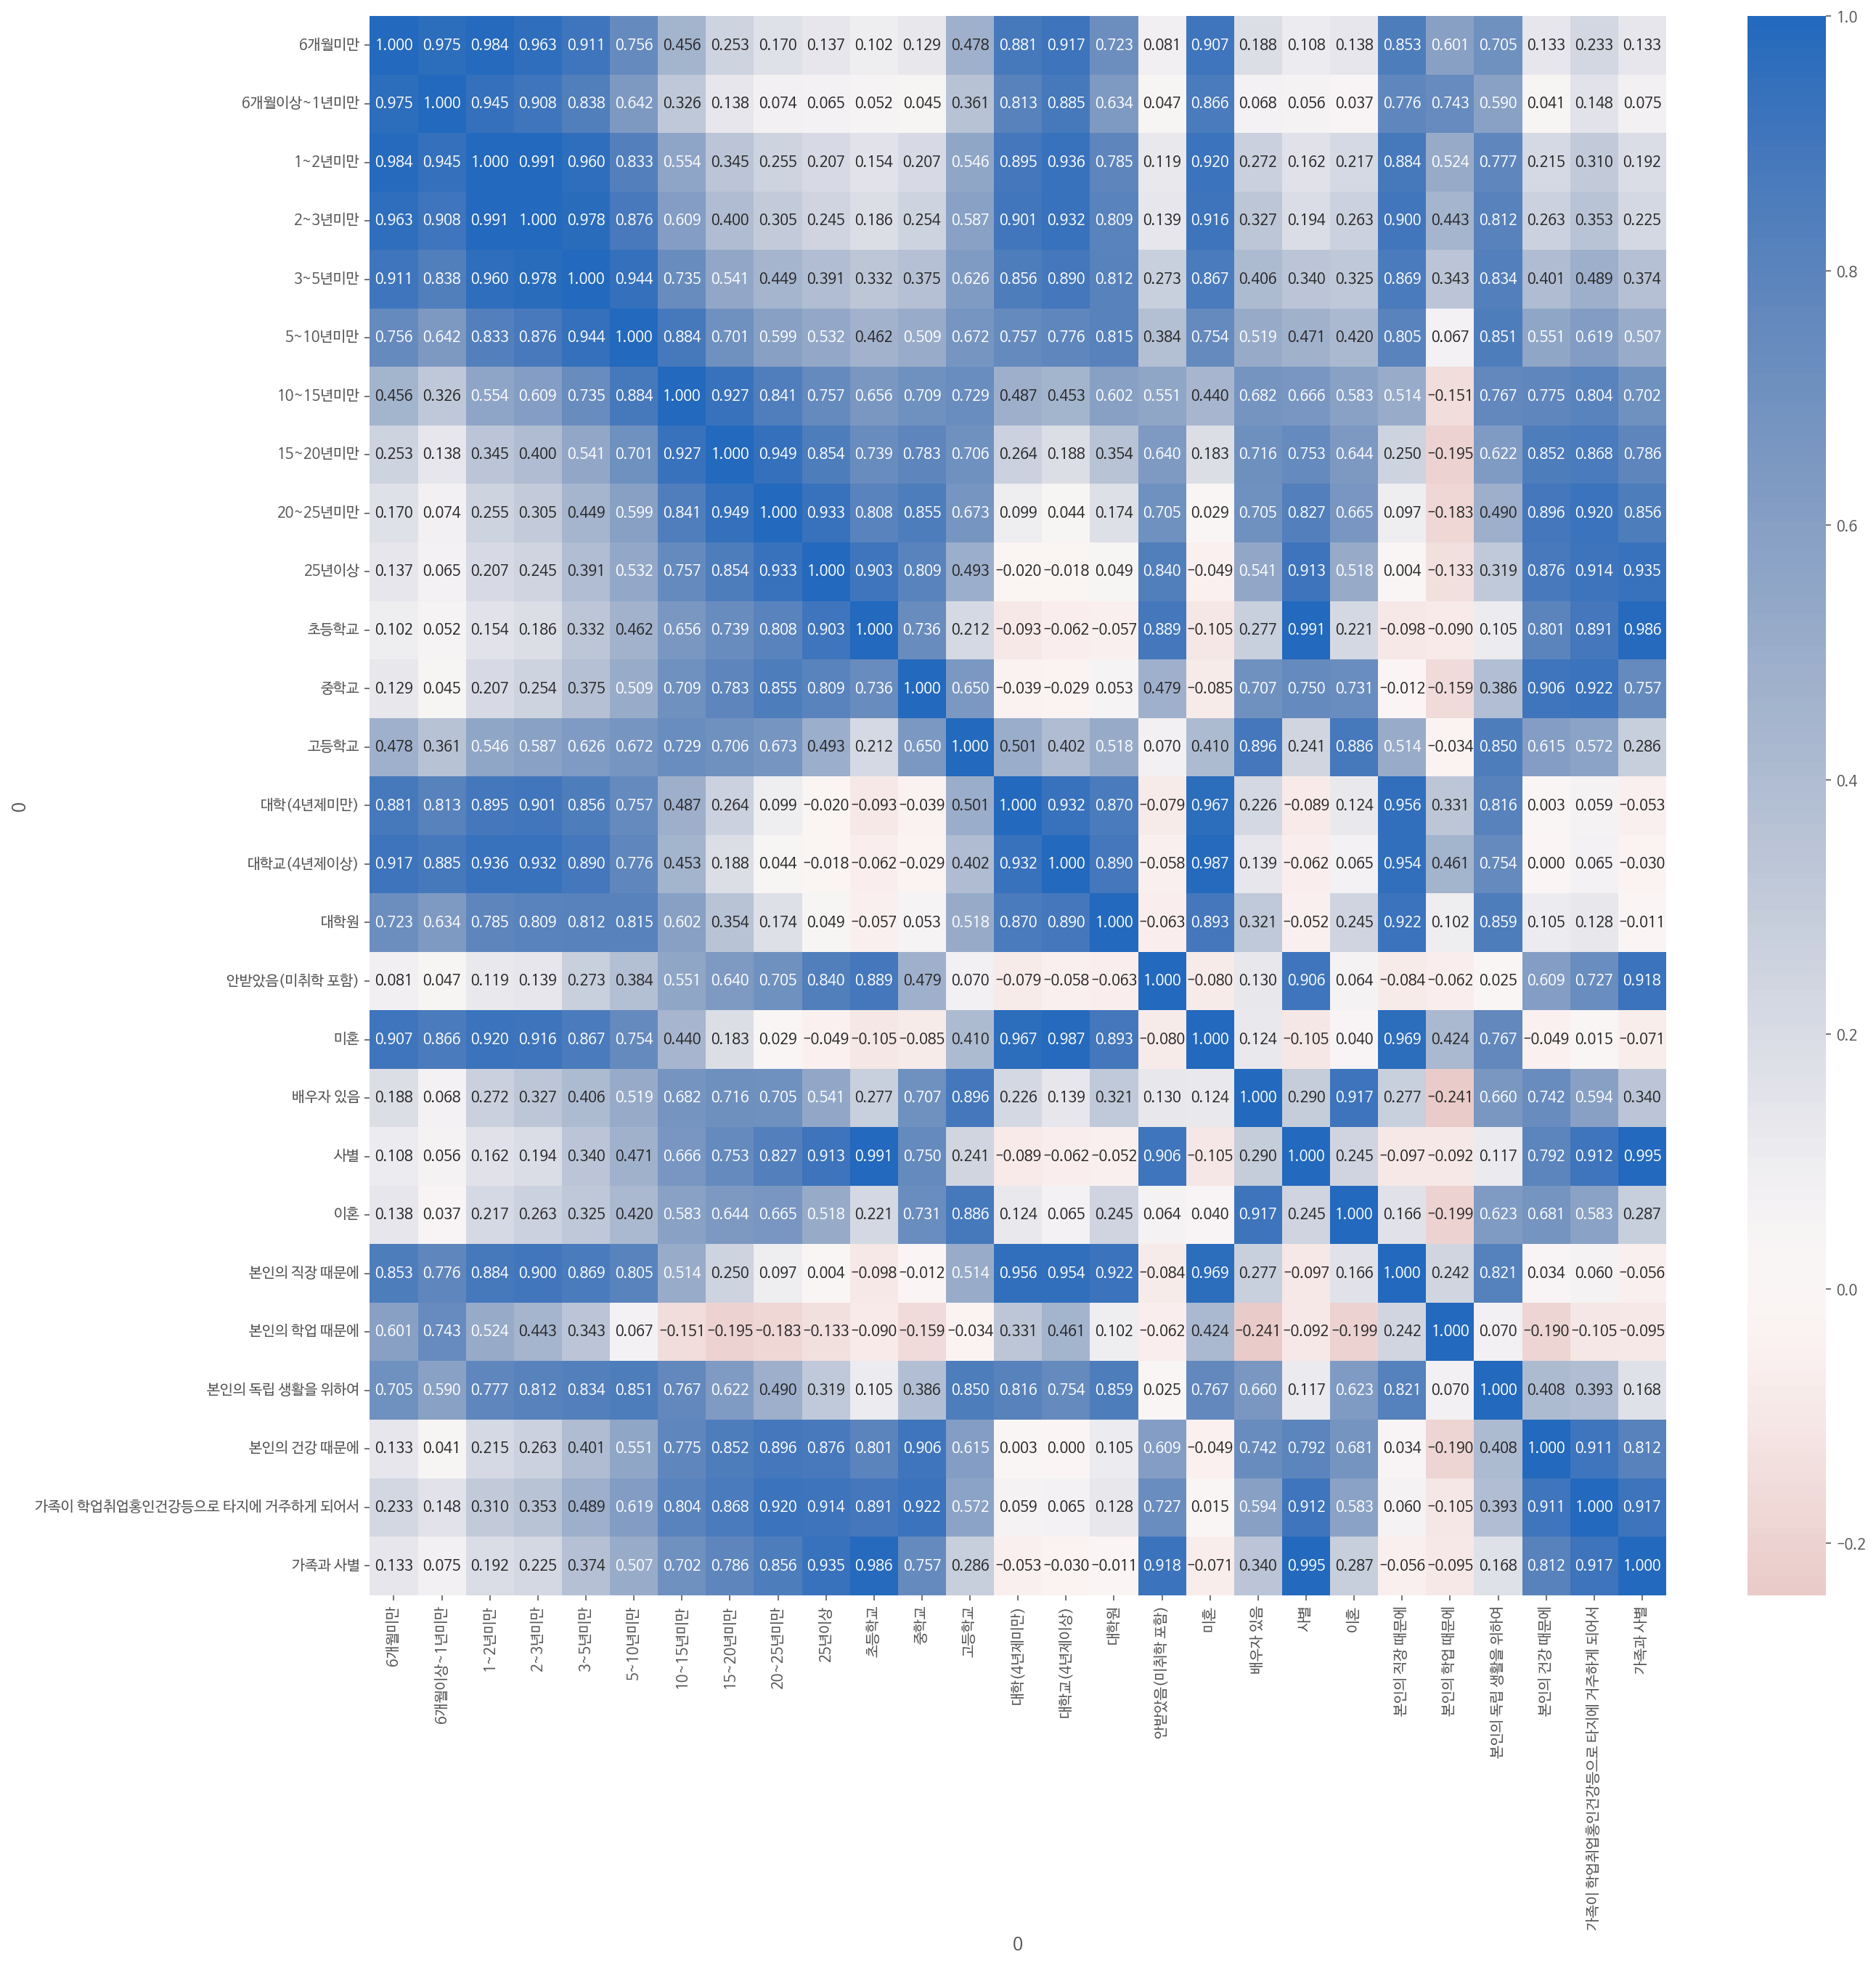

In [52]:
plt.figure(figsize=(20,20))
features = ['6개월미만', '6개월이상~1년미만',
       '1~2년미만', '2~3년미만', '3~5년미만', '5~10년미만', '10~15년미만', '15~20년미만',
       '20~25년미만', '25년이상','초등학교', '중학교', '고등학교', '대학(4년제미만)', '대학교(4년제이상)', '대학원', '안받았음(미취학 포함)',
        '미혼', '배우자 있음', '사별', '이혼', '본인의 직장 때문에', '본인의 학업 때문에', '본인의 독립 생활을 위하여', '본인의 건강 때문에',
       '가족이 학업취업홍인건강등으로 타지에 거주하게 되어서', '가족과 사별']
       
sns.heatmap(df[features].corr(), annot=True, fmt='.3f', cmap='vlag_r', center=0) 
plt.show()

# 5. 클러스터링

In [53]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.style.use("default")

In [54]:
df.columns

Index(['본인의 직장 때문에', '본인의 학업 때문에', '본인의 독립 생활을 위하여', '본인의 건강 때문에',
       '가족이 학업취업홍인건강등으로 타지에 거주하게 되어서', '가족과 사별', '기타_x', '행정구역_성별_연령', '행정구역별',
       '성별', '연령별', '1인가구-계', '6개월미만', '6개월이상~1년미만', '1~2년미만', '2~3년미만',
       '3~5년미만', '5~10년미만', '10~15년미만', '15~20년미만', '20~25년미만', '25년이상',
       '주로 일하였음', '틈틈이 일하였음', '일시 휴직', '일하지 않았음', '미상_x', '농업 임업 및 어업', '광업',
       '제조업', '전기가스증기 및공기조절 공급업', '수도 하수 및 폐기물 처리 원료 재생업', '건설업', '도매 및 소매업',
       '운수업 및 창고업', '숙박 및 음식점업', '정보통신업', '금융 및 보험업', '부동산업', '전문과학 및 기술 서비스업',
       '사업시설관리 사업지원 및 임대서비스업', '공공행정국방 및 사회보장 행정', '교육 서비스업',
       '보건업 및 사회복지 서비스업', '예술 스포츠 및 여가관련 서비스업', '협회 및 단체 수리 및 기타개인서비스업',
       '가구 내 고용활동 및 달리 분류되지 않은 자가소비 생산 활동', '국제 및 외국기관', '미상_y', '관리자',
       '전문가 및 관련 종사자', '사무 종사자', '서비스 종사자', '판매 종사자', '농림어업 숙련 종사자',
       '기능원 및 관련 기능 종사자', '장치·기계조작 및 조립 종사자', '단순 노무 종사자', '기타_y', '미상', '자기집',
       '전세(월세 없음)', '보증금 있는 월세', '보증금 없는 월세', '사글세', '무상', '미혼', '배우자 있음',
       '사별', '이혼', '초등학교', '중학교', '고등학교'

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 0 to 407
Data columns (total 77 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   본인의 직장 때문에                         408 non-null    int64 
 1   본인의 학업 때문에                         408 non-null    int64 
 2   본인의 독립 생활을 위하여                     408 non-null    int64 
 3   본인의 건강 때문에                         408 non-null    int64 
 4   가족이 학업취업홍인건강등으로 타지에 거주하게 되어서       408 non-null    int64 
 5   가족과 사별                             408 non-null    int64 
 6   기타_x                               408 non-null    int64 
 7   행정구역_성별_연령                         408 non-null    object
 8   행정구역별                              408 non-null    object
 9   성별                                 408 non-null    object
 10  연령별                                408 non-null    object
 11  1인가구-계                             408 non-null    int64 
 12  6개월미만   

In [56]:
# 군집화를 위해 수치 데이터프레임 제작
dfn = df.drop(labels=['행정구역별', '성별', '연령별', '행정구역_성별_연령'], axis=1)

In [57]:
dfn.describe()

,본인의 직장 때문에,본인의 학업 때문에,본인의 독립 생활을 위하여,본인의 건강 때문에,가족이 학업취업홍인건강등으로 타지에 거주하게 되어서,가족과 사별,기타_x,1인가구-계,6개월미만,6개월이상~1년미만,...,배우자 있음,사별,이혼,초등학교,중학교,고등학교,대학(4년제미만),대학교(4년제이상),대학원,안받았음(미취학 포함)
count,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,...,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000
mean,5582.308824,804.556373,4263.387255,252.112745,2764.394608,2523.992647,91.977941,16282.730392,928.269608,972.715686,...,2142.992647,3337.786765,2614.360294,1628.948529,1390.080882,4942.443627,1951.593137,4757.024510,862.551471,750.088235
std,9977.139888,2452.513891,5576.989878,431.142419,5153.186160,7579.068542,130.729167,21007.786855,1311.842190,1465.482999,...,2718.784255,11849.130188,4203.780356,5974.923562,2623.275873,6056.799085,3015.967679,8985.489699,1647.097549,4004.147513
min,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,171.000000,17.000000,37.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,57.000000,8.000000,30.000000,0.000000,0.000000
25%,1128.250000,0.000000,1513.250000,0.000000,423.000000,114.500000,20.750000,5290.000000,326.250000,294.000000,...,294.000000,5.000000,130.750000,0.000000,77.750000,1585.500000,426.750000,1038.750000,198.250000,0.000000
50%,2749.000000,6.000000,2389.500000,109.000000,1009.500000,391.000000,53.000000,9853.500000,511.500000,515.000000,...,1293.000000,72.500000,1209.500000,0.000000,269.500000,2986.000000,1074.500000,2036.500000,435.000000,0.000000
75%,5545.000000,200.750000,4282.750000,304.250000,3273.250000,1574.250000,97.000000,16904.250000,994.250000,1048.000000,...,2844.750000,1299.250000,3175.750000,452.250000,1760.000000,5684.250000,2083.000000,4816.000000,777.000000,0.000000
max,86299.000000,27532.000000,28171.000000,4682.000000,53911.000000,75646.000000,880.000000,153224.000000,10122.000000,12279.000000,...,18248.000000,126149.000000,27374.000000,65766.000000,22626.000000,39859.000000,21042.000000,80101.000000,12505.000000,35034.000000


In [58]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 0 to 407
Data columns (total 73 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   본인의 직장 때문에                         408 non-null    int64
 1   본인의 학업 때문에                         408 non-null    int64
 2   본인의 독립 생활을 위하여                     408 non-null    int64
 3   본인의 건강 때문에                         408 non-null    int64
 4   가족이 학업취업홍인건강등으로 타지에 거주하게 되어서       408 non-null    int64
 5   가족과 사별                             408 non-null    int64
 6   기타_x                               408 non-null    int64
 7   1인가구-계                             408 non-null    int64
 8   6개월미만                              408 non-null    int64
 9   6개월이상~1년미만                         408 non-null    int64
 10  1~2년미만                             408 non-null    int64
 11  2~3년미만                             408 non-null    int64
 12  3~5년미만                

In [59]:
from scipy.stats import zscore
# apply z-transform to every column in the dataframe
df_zscored = dfn.apply(zscore)

In [60]:
df_zscored = df_zscored.fillna(0)

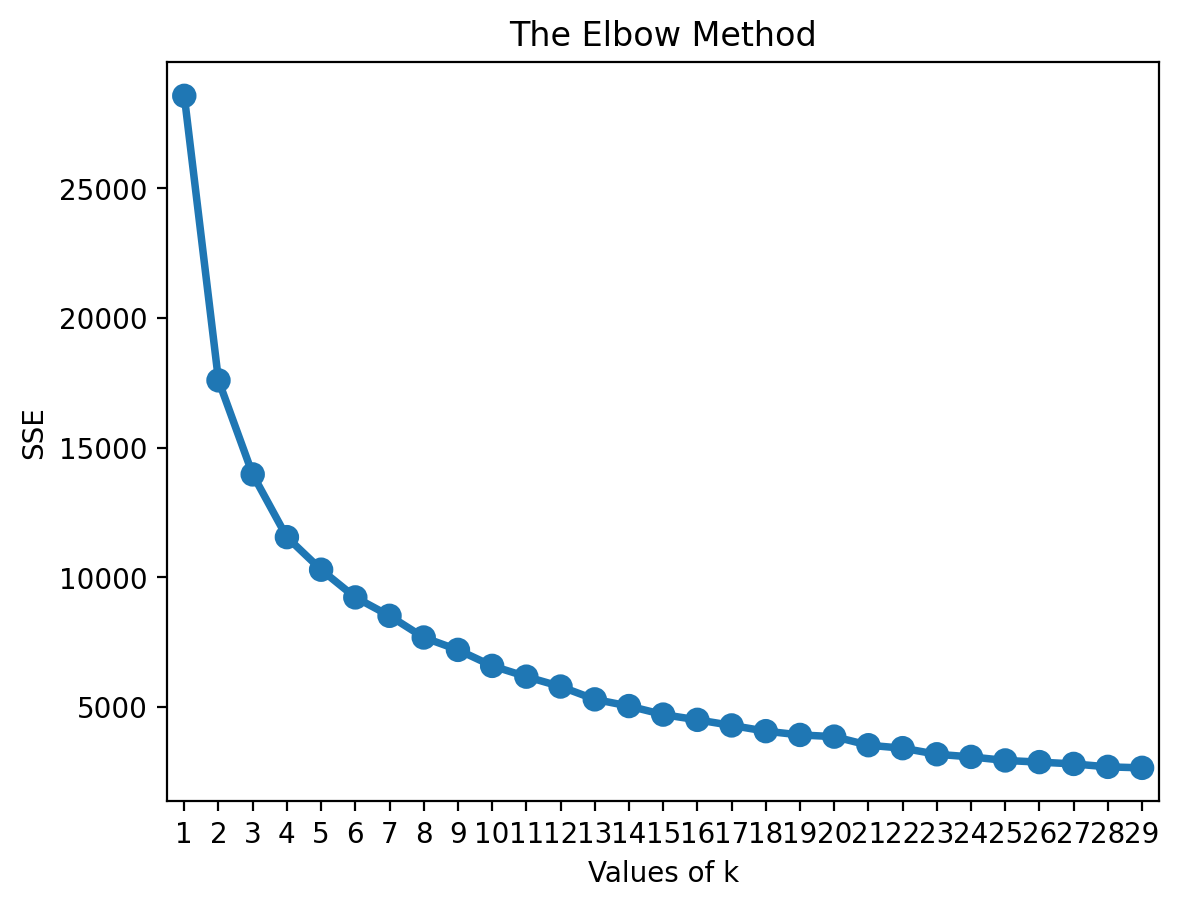

In [61]:
# z변환된 수치 데이터프레임으로 클러스터링 개수를 정한다.
sse = {}

for k in range(1,30):
  kmeans = KMeans(n_clusters=k, random_state=1)
  kmeans.fit(df_zscored)
  sse[k] = kmeans.inertia_

# 결과 시각화

plt.title('The Elbow Method')
plt.xlabel('Values of k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [62]:
# scaler = StandardScaler()
# dfn_scaled = scaler.fit_transform(dfn)
# print('mean: ', dfn_scaled.mean(axis=0).round(2))
# print('std: ', dfn_scaled.std(axis=0).round(2))

In [63]:
# # 스케일링된 수치 데이터프레임으로 클러스터링 개수를 정한다.
# sse = {}

# for k in range(1,30):
#   kmeans = KMeans(n_clusters=k, random_state=1)
#   kmeans.fit(dfn_scaled)
#   sse[k] = kmeans.inertia_

# # 결과 시각화

# plt.title('The Elbow Method')
# plt.xlabel('Values of k')
# plt.ylabel('SSE')
# sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
# plt.show()

In [64]:
# 최종 모델 학습
kmeans = KMeans(n_clusters=8, max_iter=100, random_state=42)
kmeans.fit(df_zscored)

KMeans(max_iter=100, random_state=42)

In [65]:
pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
#pd.set_option('display.max_rows', None) ## 모든 열을 출력한다.
pd.set_option('display.max_seq_items', None)

In [66]:
# 클러스터별 라벨 지정
cluster_labels = kmeans.labels_
df_k8 = df.assign(Cluster = cluster_labels)

In [67]:
df_k8_sum = df_k8.groupby(['Cluster','연령별','행정구역별']).sum()
# 매개 변수로 저장할 파일 이름을 전달합니다.
df_k8_sum.to_excel('df_k8_sum.xlsx')

In [68]:
df_k8.groupby(['Cluster','연령별','행정구역별']).sum()

0                    본인의 직장 때문에  본인의 학업 때문에  본인의 독립 생활을 위하여  본인의 건강 때문에  \
Cluster 연령별   행정구역별                                                       
0       20~24 강원도          5960       13510            2609           0   
              경기도         30015       21262           15447           0   
              경상북도         8973       15151            3659           0   
              대구광역시        4256        5317            2356           0   
              대전광역시        9935       19041            4776           0   
...                         ...         ...             ...         ...   
7       55~59 서울특별시        7195           8           14482         779   
        60~64 경기도          8730           0           18288        1019   
              서울특별시       16725           6           34168        2181   
        65~69 경기도          4074           0           13634        1148   
              서울특별시        3496           0           13109         896   

0                    가족이 학업취업홍인건강등으로 타지에 거주하게 되어서  가족과 사별  기타_x  1인가구-계  \
Cluster 연령별   행정구역별                                                       
0       20~24 강원도                             914     258   104   23355   
              경기도                            3428     999   174   71325   
              경상북도                           1436     355    54   29628   
              대구광역시                           431      97    25   12482   
              대전광역시                          1173     148     9   35082   
...                                           ...     ...   ...     ...   
7       55~59 서울특별시                         11254    4380   526   38624   
        60~64 경기도                           23349   12545   351   64282   
              서울특별시                         25448   15612   694   94834   
        65~69 경기도                           17956   16737   279   53828   
              서울특별시                         15419   14865   277   48062   

0                    6개월미만  6개월이상~1년미만  1~2년미만  2~3년미만  3~5년미만  5~10년미만  \
Cluster 연령별   행정구역별                                                       
0       20~24 강원도     3187        5218    5530    4063    4074     1283   
              경기도    11207       13479   17974   10606   12263     5796   
              경상북도    4709        5827    7002    5169    5296     1625   
              대구광역시   1426        1904    3068    2369    2733      982   
              대전광역시   4179        6665    8604    6139    6911     2584   
...                    ...         ...     ...     ...     ...      ...   
7       55~59 서울특별시   1716        1342    3746    3064    4405     6407   
        60~64 경기도     2378        2009    5816    5240    7760    12165   
              서울특별시   2941        2725    8057    6317   10200    16774   
        65~69 경기도     1877        1681    4131    3637    6484     9943   
              서울특별시   1413        1322    3707    2919    5724     9365   

0                    10~15년미만  15~20년미만  20~25년미만  25년이상  주로 일하였음  틈틈이 일하였음  \
Cluster 연령별   행정구역별                                                           
0       20~24 강원도           0         0         0      0     6122      3837   
              경기도           0         0         0      0    31439     13386   
              경상북도          0         0         0      0     8566      3565   
              대구광역시         0         0         0      0     4190      1692   
              대전광역시         0         0         0      0     8773      6706   
...                       ...       ...       ...    ...      ...       ...   
7       55~59 서울특별시      5968      3508      4812   3656    22304      1297   
        60~64 경기도       10206      5059      9002   4647    31685      1719   
              서울특별시     16041      7897     12742  11140    46502      2296   
        65~69 경기도        9329      4452      7188   5106    17722      1290   
              서울특별시      7844      3601      6182   5985    13535      1157   

0                    일시 휴직  일하지 않았음  미상_x  농

In [69]:
df_k8.loc[df_k8.행정구역_성별_연령=='서울특별시여자30~34']

,본인의 직장 때문에,본인의 학업 때문에,본인의 독립 생활을 위하여,본인의 건강 때문에,가족이 학업취업홍인건강등으로 타지에 거주하게 되어서,가족과 사별,기타_x,행정구역_성별_연령,행정구역별,성별,연령별,1인가구-계,6개월미만,6개월이상~1년미만,1~2년미만,2~3년미만,3~5년미만,5~10년미만,10~15년미만,15~20년미만,20~25년미만,25년이상,주로 일하였음,틈틈이 일하였음,일시 휴직,일하지 않았음,미상_x,농업 임업 및 어업,광업,제조업,전기가스증기 및공기조절 공급업,수도 하수 및 폐기물 처리 원료 재생업,건설업,도매 및 소매업,운수업 및 창고업,숙박 및 음식점업,정보통신업,금융 및 보험업,부동산업,전문과학 및 기술 서비스업,사업시설관리 사업지원 및 임대서비스업,공공행정국방 및 사회보장 행정,교육 서비스업,보건업 및 사회복지 서비스업,예술 스포츠 및 여가관련 서비스업,협회 및 단체 수리 및 기타개인서비스업,가구 내 고용활동 및 달리 분류되지 않은 자가소비 생산 활동,국제 및 외국기관,미상_y,관리자,전문가 및 관련 종사자,사무 종사자,서비스 종사자,판매 종사자,농림어업 숙련 종사자,기능원 및 관련 기능 종사자,장치·기계조작 및 조립 종사자,단순 노무 종사자,기타_y,미상,자기집,전세(월세 없음),보증금 있는 월세,보증금 없는 월세,사글세,무상,미혼,배우자 있음,사별,이혼,초등학교,중학교,고등학교,대학(4년제미만),대학교(4년제이상),대학원,안받았음(미취학 포함),Cluster
14,51862,631,23643,179,3621,1187,203,서울특별시여자30~34,서울특별시,여자,30~34,81326,4438,4435,10467,7782,13219,23206,15870,1909,0,0,64980,3631,2868,9847,0,35,9,4604,32,52,934,12537,1734,4337,7581,4034,841,9500,3170,2671,6337,8146,1931,2905,43,46,0,119,29647,24931,6701,7040,20,1153,334,1511,23,0,8334,31856,37320,1732,106,1978,77491,2338,54,1443,0,121,6921,14167,48838,11279,0,1


In [70]:
def get_counts(seq): 
    counts = {}
    for x in seq:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

## way 1
## reference: https://rfriend.tistory.com/473
def top_n(count_dict, n=3):
    return sorted(count_dict.items(), reverse=True, key=lambda x: x[1])[:n]

In [71]:
city_0 = df_k8.loc[df_k8['Cluster']== 0].행정구역별.tolist()
counts = get_counts(city_0)
## getting top 3
top_n(counts, n=3)

[('부산광역시', 6), ('충청남도', 6), ('대구광역시', 5)]

In [72]:
sex_0 = df_k8.loc[df_k8['Cluster']== 0].성별.tolist()
counts = get_counts(sex_0)
top_n(counts, n=2)

[('남자', 35), ('여자', 15)]

In [73]:
age_0 = df_k8.loc[df_k8['Cluster']== 0].연령별.tolist()
counts = get_counts(age_0)
top_n(counts, n=3)

[('20~24', 18), ('25~29', 18), ('30~34', 10)]

In [74]:
df_k8.행정구역별.unique()

array(['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시',
       '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도',
       '경상남도', '제주특별자치도'], dtype=object)

In [75]:
df_k8.연령별.unique()

array(['20 미만', '20~24', '25~29', '30~34', '35~39', '40~44', '45~49',
       '50~54', '55~59', '60~64', '65~69', '70 이상'], dtype=object)

In [76]:
cluster_num = 1

In [77]:
## getting top 3

age_1 = df_k8.loc[df_k8['Cluster']== cluster_num].연령별.tolist()
count_age = get_counts(age_1)
a=top_n(count_age, n=3)

sex_1 = df_k8.loc[df_k8['Cluster']== cluster_num].성별.tolist()
count_sex = get_counts(sex_1)
b=top_n(count_sex, n=2)

city_1 = df_k8.loc[df_k8['Cluster']== cluster_num].행정구역별.tolist()
count_city = get_counts(city_1)
c=top_n(count_city, n=3)

a,b,c

([('25~29', 4), ('30~34', 3), ('35~39', 1)],
 [('남자', 5), ('여자', 4)],
 [('서울특별시', 6), ('경기도', 3)])